In [1]:
# Import needed files and basic setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

import numpy as np

from sklearn import linear_model

import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import itertools

from IPython.display import display, Latex

%matplotlib notebook
plt.ion()
plt.rcParams['figure.figsize'] = (7, 7)

#%load_ext tikzmagic

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # I don't have a GPU to test this

In [2]:
%%HTML

<style>
.rendered_html table, .rendered_html td, .rendered_html th {
    font-size: 150%;
}
</style>

# XOR

| x | y | XOR(x, y) |
|---|---|---|
| -1 | -1 | -1 |
| -1 | 1 | 1 |
| 1 | -1 | 1 |
| 1 | 1 | -1 |

<IPython.core.display.Javascript object>


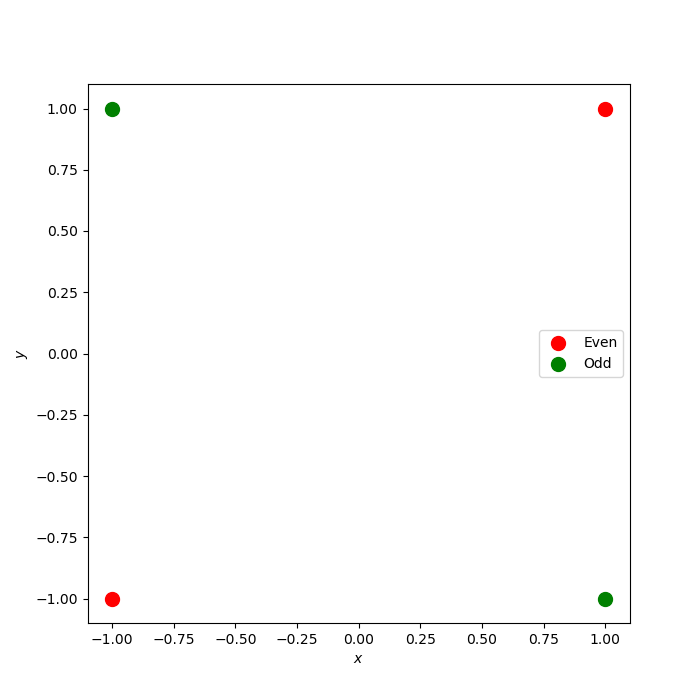

In [3]:
# XOR
fig, ax = plt.subplots()
ax.scatter([-1, 1], [-1, 1], c='r', alpha=1, s=100, label='Even');
ax.scatter([1, -1], [-1, 1], c='g', alpha=1, s=100, label='Odd');
ax.legend()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

<IPython.core.display.Javascript object>


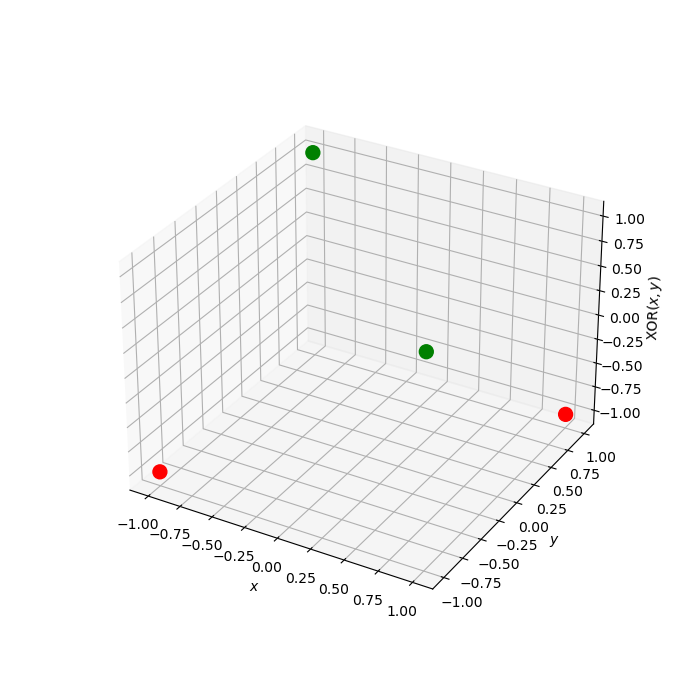

In [4]:
# Plot 3D XOR
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter([-1, 1], [-1, 1], [-1, -1], c='r', alpha=1, s=100);
ax.scatter([1, -1], [-1, 1], [1, 1], c='g', alpha=1, s=100);

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('XOR$(x, y)$');

In [77]:
# Setup parameters
a = np.array([[2.0], [-4.0]]).T

bOuter = np.array(-1)

bInner = np.array([[1.0], 
                   [0.0]])

w = np.array([[1.0, 1.0], 
              [1.0, 1.0]])

def network(x):
    return np.matmul(a, np.maximum(np.matmul(w, x) + bInner, 0)) + bOuter

<IPython.core.display.Javascript object>


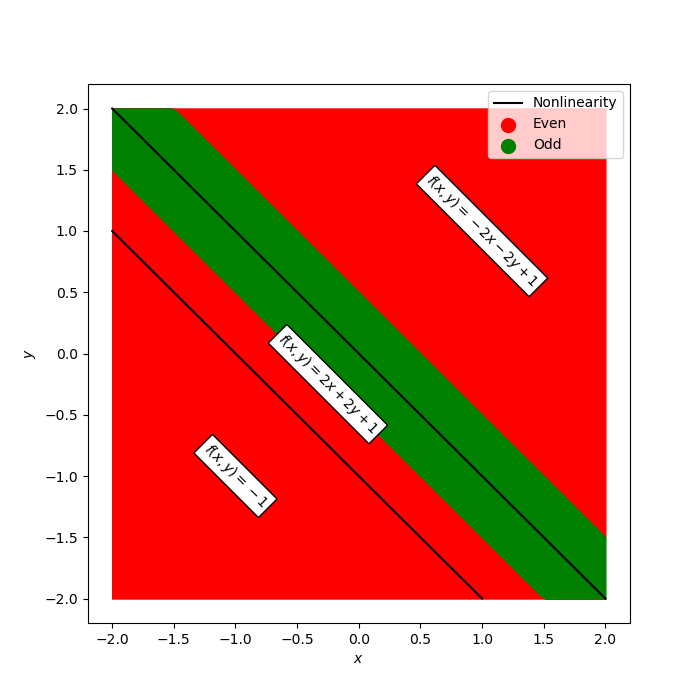

In [106]:
# XOR
fig, ax = plt.subplots()


# y = (1-2x)/2
# y = (3-2x)/2
x = np.linspace(-2, 2, 100)
ax.fill_between(x, -2, np.clip((-x-0.5), -2, 2), color='r')
ax.fill_between(x, np.clip((-x+0.5), -2, 2), 2, color='r')
ax.fill_between(x, np.clip((-x-0.5), -2, 2), np.clip((-x+0.5), -2, 2), color='g')

ax.plot([2, -2], [-2, 2], c='k', label='Nonlinearity')
ax.plot([1, -2], [-2, 1], c='k');

ax.scatter([-1, 1], [-1, 1], c='r', alpha=1, s=100, label='Even');
ax.scatter([1, -1], [-1, 1], c='g', alpha=1, s=100, label='Odd');

plt.text(-1, -1, "$f(x,y) = -1$", size=10, rotation=-45, ha="center", va="center", bbox=dict(boxstyle="square", ec=(0, 0, 0), fc=(1, 1, 1)))

plt.text(-0.25, -0.25, "$f(x,y) = 2x+2y+1$", size=10, rotation=-45, ha="center", va="center", bbox=dict(boxstyle="square", ec=(0, 0, 0), fc=(1, 1, 1)))

plt.text(1, 1, "$f(x,y) = -2x-2y+1$", size=10, rotation=-45, ha="center", va="center", bbox=dict(boxstyle="square", ec=(0, 0, 0), fc=(1, 1, 1)))

ax.legend()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

<IPython.core.display.Javascript object>


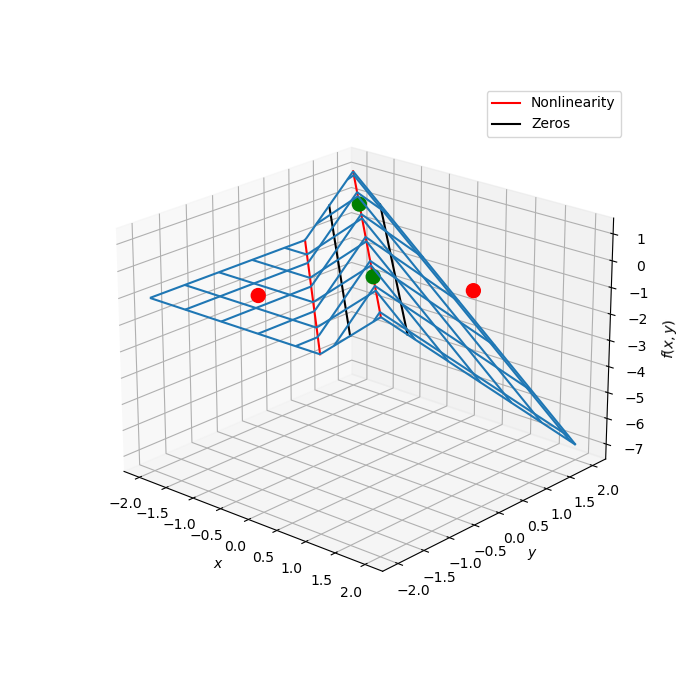

In [86]:
# Plot this
x = np.array([0, 1])
y = np.array([0, 1])

x, y = np.meshgrid(x, y)
X = x.reshape([-1, 1])
Y = y.reshape([-1, 1])

into = np.concatenate((X, Y), axis=1)

out = network(into.T)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.array([0, 1])
y = np.array([0, 1])

x, y = np.meshgrid(x, y)
X = x.reshape([-1, 1])
Y = y.reshape([-1, 1])

into = np.concatenate((X, Y), axis=1)

out = network(into.T)


x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)

x, y = np.meshgrid(x, y)
X = x.reshape([-1, 1])
Y = y.reshape([-1, 1])

into = np.concatenate((X, Y), axis=1)

out = network(into.T)


ax.plot([2, -2], [-2, 2], zs=[1, 1], c='r', label='Nonlinearity')

ax.plot([1, -2], [-2, 1], zs=[-1, -1], c='r');


ax.plot_wireframe(x, y, out.reshape(x.shape), rstride=16, cstride=16);

ax.scatter([-1, 1], [-1, 1], [-1, -1], c='r', alpha=1, s=100);
ax.scatter([1, -1], [-1, 1], [1, 1], c='g', alpha=1, s=100);

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$f(x,y)$')

# y = (1-2x)/2
# y = (3-2x)/2
#ax.plot([-1/2, 2], [2, -1/2], 'k');
#ax.plot([-1, 1.5], [3/2, -1], 'k');

ax.plot([-1.5, 2], [2, -1.5], zs=[0, 0], c='k', label='Zeros');
ax.plot([-2, 1.5], [1.5, -2], zs=[0, 0], c='k');

ax.legend();



#ax.plot([0, 1], [1, 0], zs=[-1, -1], c='k')
#ax.plot([0, 1], [-1, -2], zs=[-1, -1], c='k')

# Trained networks

In [58]:
class SimpleNet(torch.nn.Module):
    def __init__(self, width=2):
        super(SimpleNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, width)
        self.fc2 = torch.nn.Linear(width, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [59]:
def get_dataloader(dim=2, train=True):
    if train == True:
        train_x = []
        train_y = []
        for val in itertools.product([0, 1], repeat=dim):
            train_x.append(2*(np.array(val) - 0.5))
            train_y.append(2*np.array([sum(val) % 2]) - 1)

        tensor_x = torch.stack([torch.tensor(elem.astype(np.float32)) for elem in train_x])
        tensor_y = torch.stack([torch.tensor(elem.astype(np.float32)) for elem in train_y])

        my_dataset = torch.utils.data.TensorDataset(tensor_x, tensor_y)
        return torch.utils.data.DataLoader(my_dataset, batch_size=len(train_x), shuffle=True)
    else:
        x = np.linspace(-1, 1, 101)
        y = np.linspace(-1, 1, 101)
        x, y = np.meshgrid(x, y)
        X = x.reshape([-1, 1])
        Y = y.reshape([-1, 1])
        into = np.concatenate((X, Y), axis=1)
        train_x = []
        for i in range(into.shape[0]):
            train_x.append(into[i, :])
        
        #tensor_x = torch.stack([torch.tensor(elem.astype(np.float32)) for elem in train_x])

        #my_dataset = torch.utils.data.TensorDataset(tensor_x, tensor_x)
        #return torch.utils.data.DataLoader(my_dataset, batch_size=1, shuffle=False)
        
        for val in itertools.product([0, 1], repeat=dim):
            train_x.append(2*(np.array(val) - 0.5))

        tensor_x = torch.stack([torch.tensor(elem.astype(np.float32)) for elem in train_x])

        my_dataset = torch.utils.data.TensorDataset(tensor_x, tensor_x)
        return torch.utils.data.DataLoader(my_dataset, batch_size=1, shuffle=False)

In [60]:
def train(network, optimizer, lossFunc, train_loader):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = lossFunc(output, target)
        loss.backward()
        optimizer.step()
        
def test(network, test_loader):
    network.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            pred = output > 0
            tar = target > 0
            correct += pred.eq(tar.data.view_as(pred)).sum()
    return correct.item()/len(test_loader.dataset)

In [61]:
def printStructure(network):
    A1 = 2*network.fc1.weight.detach().numpy()
    b1 = network.fc1.bias.detach().numpy() - np.matmul(A1, 0.5*np.ones(2))

    A2 = network.fc2.weight.detach().numpy()
    b2 = network.fc2.bias.detach().numpy()

    text = r'''\begin{{equation*}}
    f(x) = \begin{{bmatrix}} {} & {} \end{{bmatrix}} \max \left\{{ \begin{{bmatrix}} {} & {} \\ {} & {} \end{{bmatrix}} \begin{{bmatrix}} x_1 \\ x_2 \end{{bmatrix}} + \begin{{bmatrix}} {} \\ {} \end{{bmatrix}}, 0 \right\}} - ({})
    \end{{equation*}}'''.format(A2[0,0], A2[0,1], A1[0,0], A1[0,1], A1[1,0], A1[1,0], b1[0], b1[1], b2[0])
    display(Latex(text))

In [62]:
def trainNet(network, width=2):
    x = np.linspace(-1, 1, 101)
    y = np.linspace(-1, 1, 101)
    x, y = np.meshgrid(x, y)
    X = x.reshape([-1, 1])
    Y = y.reshape([-1, 1])
    into = np.concatenate((X, Y), axis=1)
    into = torch.tensor(into.astype(np.float32))
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, projection='3d')
    
    X = X/2 + 0.5
    Y = Y/2 + 0.5
    
    x = x/2 + 0.5
    y = y/2 + 0.5
    
    
    acc = 0
    while acc < 0.99:
        criterion = torch.nn.MSELoss()
        network.__init__(width=width)
        #optimizer = torch.optim.SGD(network.parameters(), 0.1, momentum=0.9, weight_decay=1e-4)
        optimizer = torch.optim.SGD(network.parameters(), 0.1)
        
        out = network(into).detach().numpy()
        ax.clear()
        ax2.clear()
        ax.plot(X[out>0], Y[out>0], '.r')
        ax.plot(X[out<0], Y[out<0], '.g')
        ax.set_title(str(0) + " " + str(acc))
        
        ax2.plot_wireframe(x, y, out.reshape(x.shape), rstride=16, cstride=16);
        ax2.scatter([0, 1], [0, 1], [-1, -1], c='r', alpha=1, s=100);
        ax2.scatter([1, 0], [0, 1], [1, 1], c='g', alpha=1, s=100);
        ax2.set_title(str(0) + " " + str(acc))
        fig.canvas.draw()


        for i in range(1, 101):
            train(network, optimizer, criterion, dataLoader)
            acc = test(network, dataLoader)

            if i % 10 == 0:
                out = network(into).detach().numpy()
                ax.clear()
                ax2.clear()
                
                ax.plot(X[out<0], Y[out<0], '.r')
                ax.plot(X[out>0], Y[out>0], '.g')
                
                ax.scatter([0, 1], [0, 1], c='r', alpha=1, s=100, label='Even');
                ax.scatter([1, 0], [0, 1], c='g', alpha=1, s=100, label='Odd');
                
                ax.legend()
                ax.set_xlabel('$x$')
                ax.set_ylabel('$y$');
                
                ax.set_title(str(i) + " epochs " + str(acc) + " accuracy")
                
                
                ax2.plot_wireframe(x, y, out.reshape(x.shape), rstride=16, cstride=16);
                ax2.scatter([0, 1], [0, 1], [-1, -1], c='r', alpha=1, s=100);
                ax2.scatter([1, 0], [0, 1], [1, 1], c='g', alpha=1, s=100);
                ax2.set_title(str(i) + " " + str(acc))
                
                fig.canvas.draw()

/home/ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


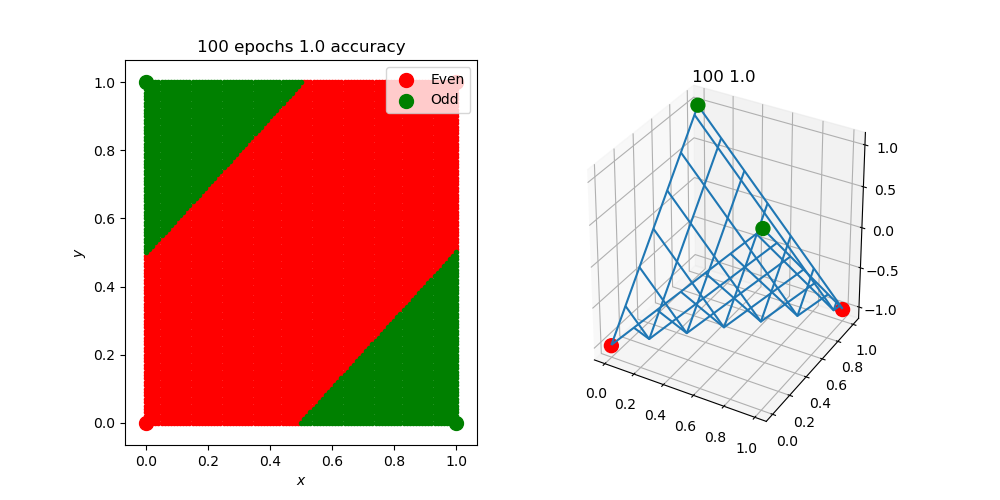

In [67]:
dataLoader = get_dataloader()
network = SimpleNet()
trainNet(network)

In [68]:
printStructure(network)

<IPython.core.display.Latex object>

/home/ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


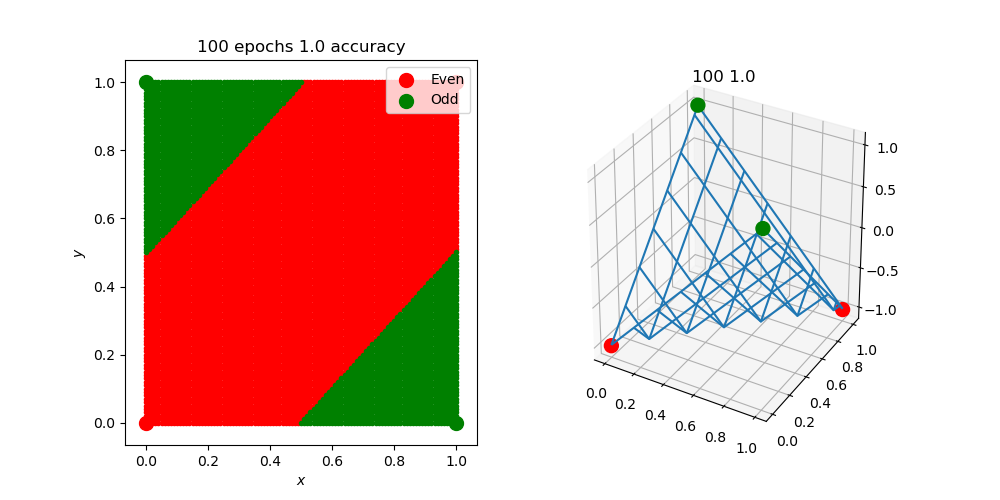

In [69]:
dataLoader = get_dataloader()
network2 = SimpleNet()
trainNet(network2)

In [70]:
printStructure(network2)

<IPython.core.display.Latex object>

# Get linear regions

In [71]:
def calcRegion(network, data):
    network.zero_grad()
    output = network(data)
    g = torch.autograd.grad(output, data)[0].data
    return np.squeeze(np.array(g.tolist()[0] + [(output[0, 0] - torch.dot(torch.squeeze(data), torch.squeeze(g))).tolist()]))

def getRegions(network, network2):
    dataLoader = get_dataloader(train=False)
    inputs = np.zeros((len(dataLoader), 2))
    regions = np.zeros((len(dataLoader), 3))
    regions2 = np.zeros((len(dataLoader), 3))
    
    for batch_idx, (data, target) in enumerate(dataLoader):
        data.requires_grad_()
        regions[batch_idx, :] = calcRegion(network, data)

    for batch_idx, (data, target) in enumerate(dataLoader):
        data.requires_grad_()
        regions2[batch_idx, :] = calcRegion(network2, data)
        
        inputs[batch_idx, :] = np.squeeze(np.array(data.tolist()))
    return inputs, regions, regions2

In [72]:
class NumpyLinearRegression:
    def __init__(self, doAll=True):
        self.doAll=doAll
        self.reg = linear_model.LinearRegression(fit_intercept=True)
        
    def fit(self, X, y):
        # Prevent the regression from fitting precision errors
        X = np.round(X, decimals=5)
        y = np.round(y, decimals=5)
        if self.doAll:
            self.reg.fit(X, y)
        else:
            self.reg.fit(X[-4:,:], y[-4:,:])
        
    def predict(self, X):
        return self.reg.predict(X)
    
    def test(self, X, y):
        return self.reg.score(X, y)

In [73]:
# Get regions and transforms
inputs, regions, regions2 = getRegions(network, network2)

reg = NumpyLinearRegression()
reg.fit(regions, regions2)

reg2 = NumpyLinearRegression()
reg2.fit(regions2, regions)

In [74]:
def calcUniqueRegions(regions):
    regionsSet = []
    for i in range(regions.shape[0]):
        isGood = True
        for elem in regionsSet:
            if np.linalg.norm(regions[i, :] - elem) < 0.001:
                isGood = False
                break
        if isGood:
            regionsSet.append(regions[i, :])
    return regionsSet
regionsSet = np.array(calcUniqueRegions(regions))
regions2Set = np.array(calcUniqueRegions(regions2))

In [75]:
def plotLinearRegions(regionsSet, regions2Set, reg, reg2):
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, projection='3d')

    tmp = reg.predict(regionsSet)
    tmp2 = reg2.predict(regions2Set)

    fig.suptitle('Linear Regions')

    ax1.plot(regionsSet[:, 0], regionsSet[:,1], 'ob', label='1')
    ax1.plot(regions2Set[:, 0], regions2Set[:,1], 'or', label='2')
    ax1.plot(tmp[:, 0], tmp[:, 1], '.m', label='1 -> 2')
    ax1.plot(tmp2[:, 0], tmp2[:, 1], '.c', label='2 -> 1')

    ax1.legend()
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')

    ax2.scatter(regionsSet[:, 0], regionsSet[:, 1], regionsSet[:, 2], color='b', label='1')
    ax2.scatter(tmp[:, 0], tmp[:, 1], tmp[:, 2], color='m', label='1 -> 2')
    ax2.scatter(tmp2[:, 0], tmp2[:, 1], tmp2[:, 2], color='c', label='2 -> 1')
    ax2.scatter(regions2Set[:, 0], regions2Set[:, 1], regions2Set[:, 2], color='r', label='2')

    ax2.legend()

    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('bias');

In [76]:
def plotSurfaces(inputs, regions, regions2, reg, reg2):
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)

    biasInputs = np.concatenate((inputs, np.ones((inputs.shape[0], 1))), 1)

    outputs = np.sum(np.multiply(biasInputs, regions), axis=1)
    ax1.plot(inputs[outputs>0, 0], inputs[outputs>0, 1], '.g', alpha=0.5)
    ax1.plot(inputs[outputs<0, 0], inputs[outputs<0, 1], '.r', alpha=0.5)
    ax1.set_title('Network 1')

    outputs = np.sum(np.multiply(biasInputs, reg.predict(regions)), axis=1)
    ax2.plot(inputs[outputs>0, 0], inputs[outputs>0, 1], '.g', alpha=0.5)
    ax2.plot(inputs[outputs<0, 0], inputs[outputs<0, 1], '.r', alpha=0.5)
    ax2.set_title('Network 1 -> Network 2')

    outputs = np.sum(np.multiply(biasInputs, reg2.predict(regions2)), axis=1)
    ax3.plot(inputs[outputs>0, 0], inputs[outputs>0, 1], '.g', alpha=0.5)
    ax3.plot(inputs[outputs<0, 0], inputs[outputs<0, 1], '.r', alpha=0.5)
    ax3.set_title('Network 2 -> Network 1')

    outputs = np.sum(np.multiply(biasInputs, regions2), axis=1)
    ax4.plot(inputs[outputs>0, 0], inputs[outputs>0, 1], '.g', alpha=0.5)
    ax4.plot(inputs[outputs<0, 0], inputs[outputs<0, 1], '.r', alpha=0.5)
    ax4.set_title('Network 2');

In [77]:
def plotWireframes(inputsTest, regionsTest, regions2Test, reg, reg2):
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(221, projection='3d')
    ax2 = fig.add_subplot(222, projection='3d')
    ax3 = fig.add_subplot(223, projection='3d')
    ax4 = fig.add_subplot(224, projection='3d')
    
    biasInputs = np.concatenate((inputs, np.ones((inputs.shape[0], 1))), 1)

    ax1.scatter(inputsTest[:, 0], inputsTest[:, 1], np.sum(np.multiply(biasInputs, regionsTest), axis=1), s=1)
    ax2.scatter(inputsTest[:, 0], inputsTest[:, 1], np.sum(np.multiply(biasInputs, reg.predict(regionsTest)), axis=1), s=1)
    ax3.scatter(inputsTest[:, 0], inputsTest[:, 1], np.sum(np.multiply(biasInputs, reg2.predict(regions2Test)), axis=1), s=1)
    ax4.scatter(inputsTest[:, 0], inputsTest[:, 1], np.sum(np.multiply(biasInputs, regions2Test), axis=1), s=1)

/home/ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


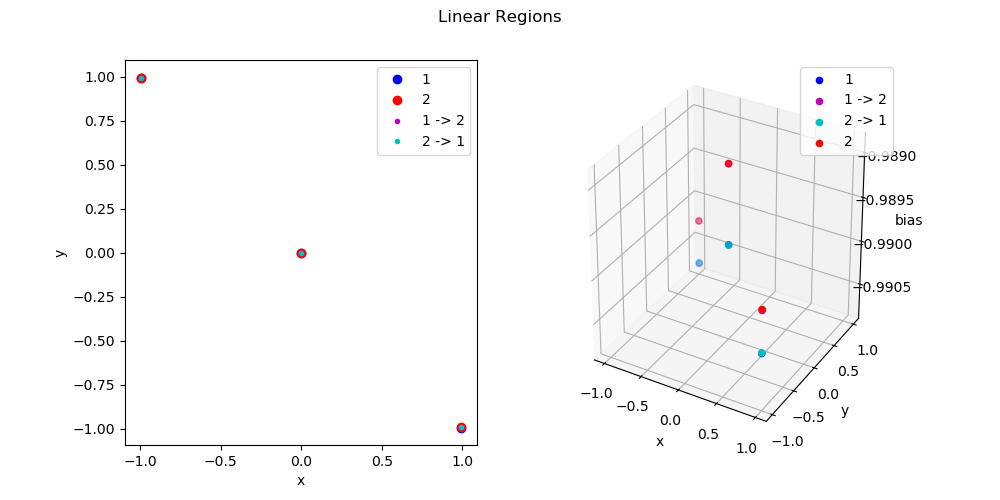

In [78]:
plotLinearRegions(regionsSet, regions2Set, reg, reg2)

/home/ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


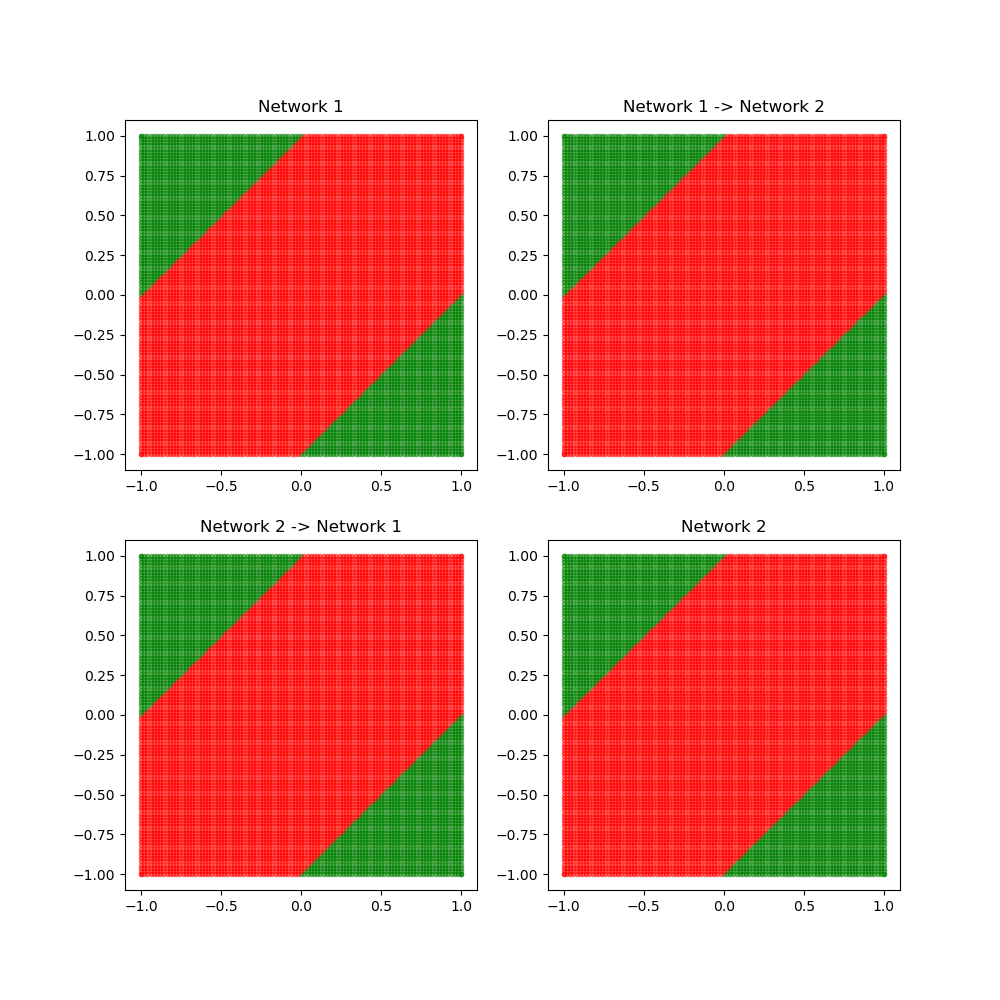

In [79]:
plotSurfaces(inputs, regions,regions2, reg, reg2)

/home/ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


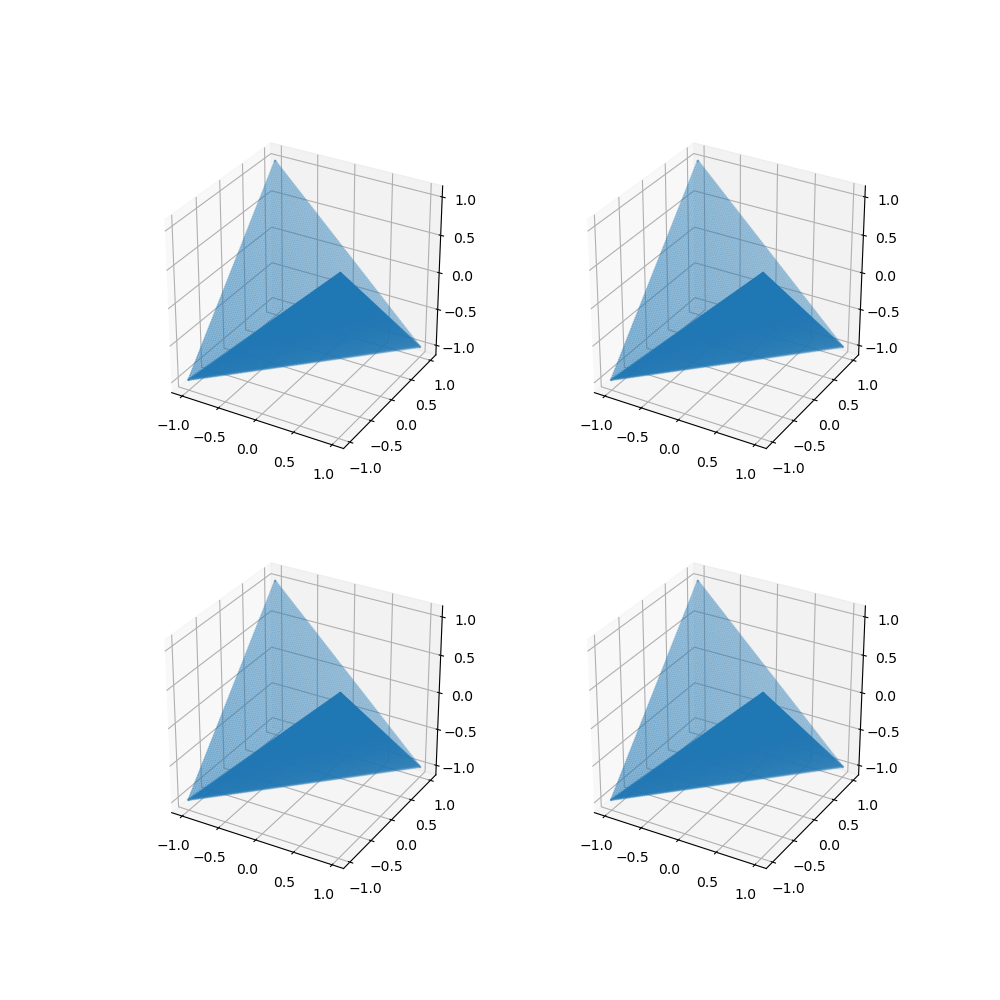

In [80]:
plotWireframes(inputs, regions, regions2, reg, reg2)

# Dissimilar networks

/home/ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


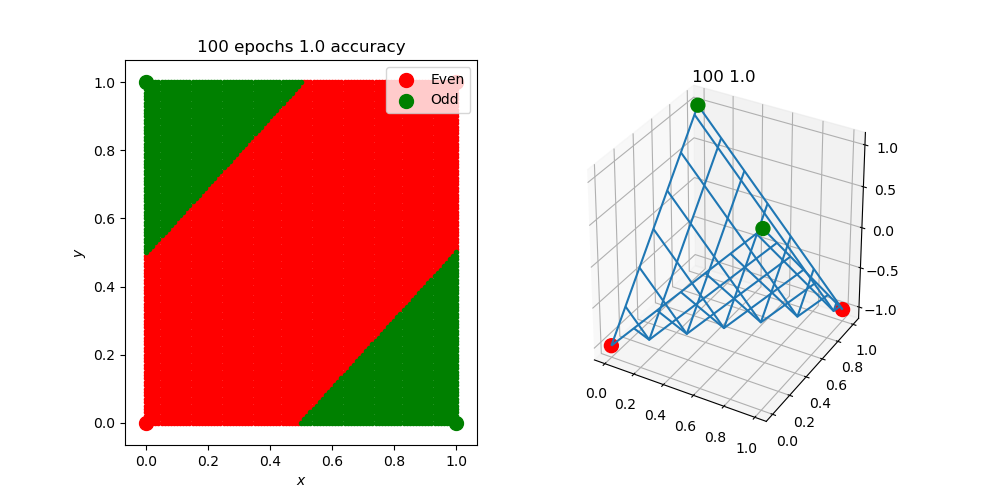

In [91]:
dataLoader = get_dataloader()
network = SimpleNet()
trainNet(network)

In [92]:
printStructure(network)

<IPython.core.display.Latex object>

/home/ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


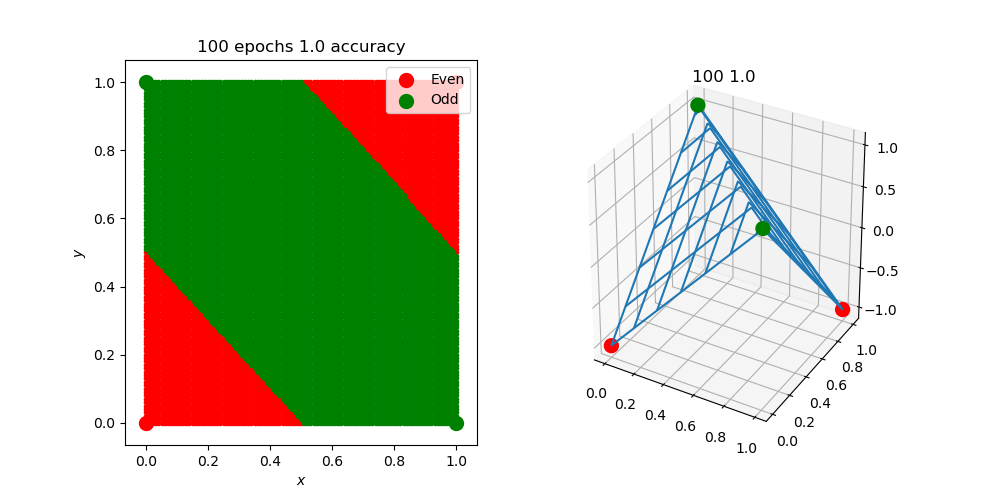

In [96]:
network2 = SimpleNet()
trainNet(network2)

In [94]:
printStructure(network2)

<IPython.core.display.Latex object>

In [97]:
# Get regions and transforms
inputs, regions, regions2 = getRegions(network, network2)

reg = NumpyLinearRegression()
reg.fit(regions, regions2)

reg2 = NumpyLinearRegression()
reg2.fit(regions2, regions)

regionsSet = np.array(calcUniqueRegions(regions))
regions2Set = np.array(calcUniqueRegions(regions2))

print(len(regionsSet), len(regions2Set))

3 3


/home/ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


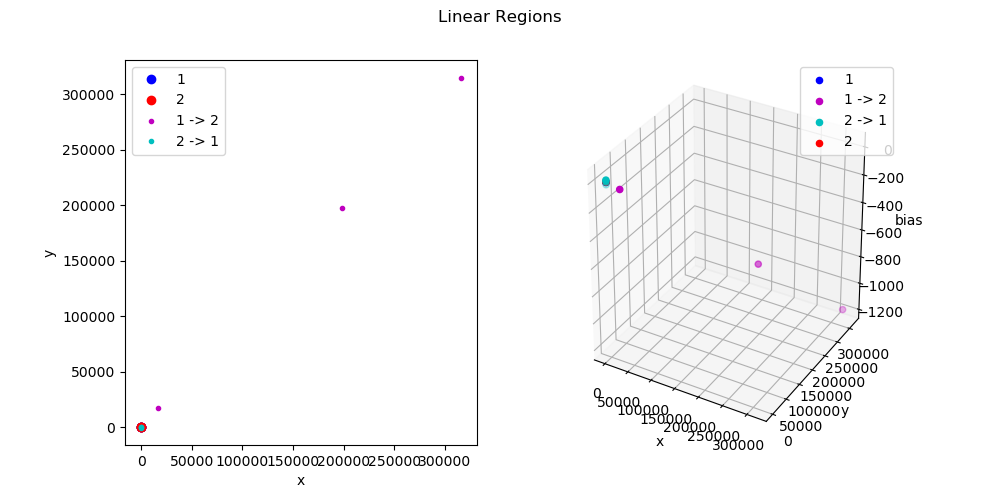

In [98]:
if len(regionsSet) < 100:
    plotLinearRegions(regionsSet, regions2Set, reg, reg2)

/home/ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


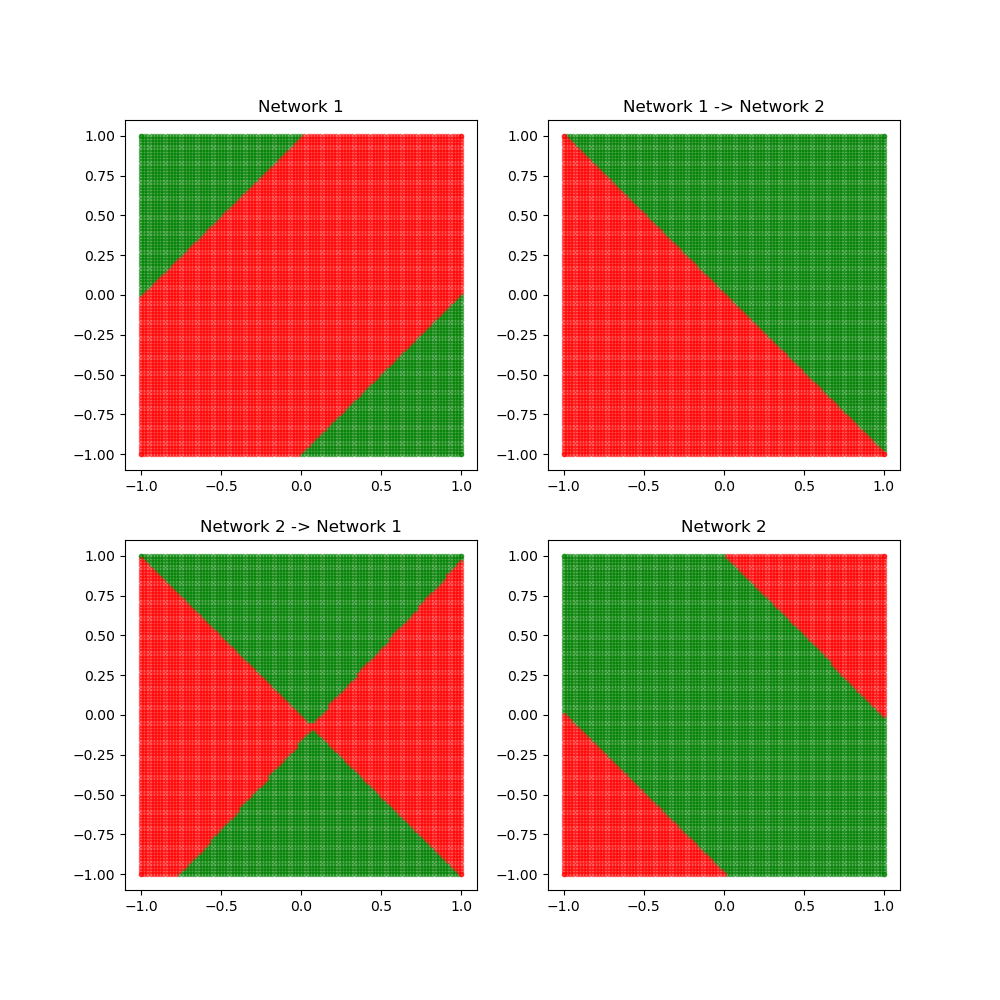

In [99]:
plotSurfaces(inputs, regions,regions2, reg, reg2)

/home/ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


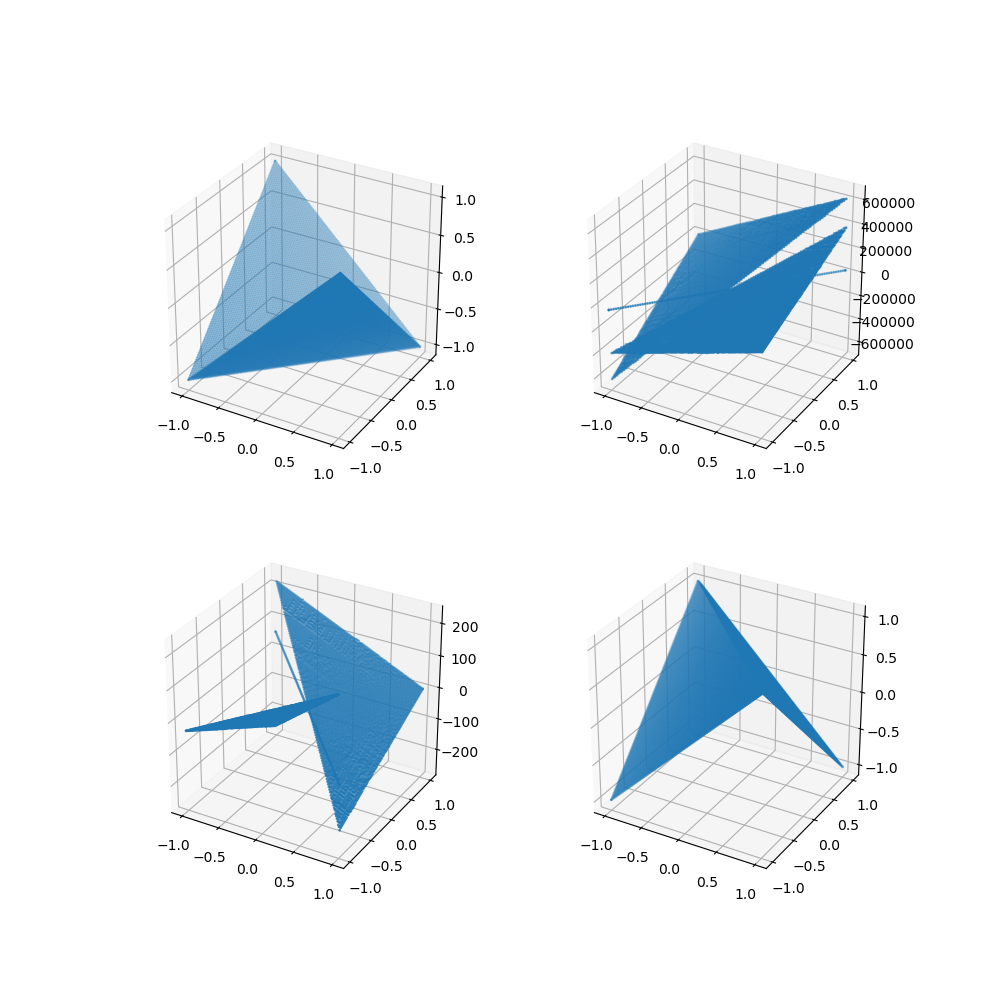

In [100]:
plotWireframes(inputs, regions, regions2, reg, reg2)

# Width 20 networks

In [37]:
width = 20

<IPython.core.display.Javascript object>


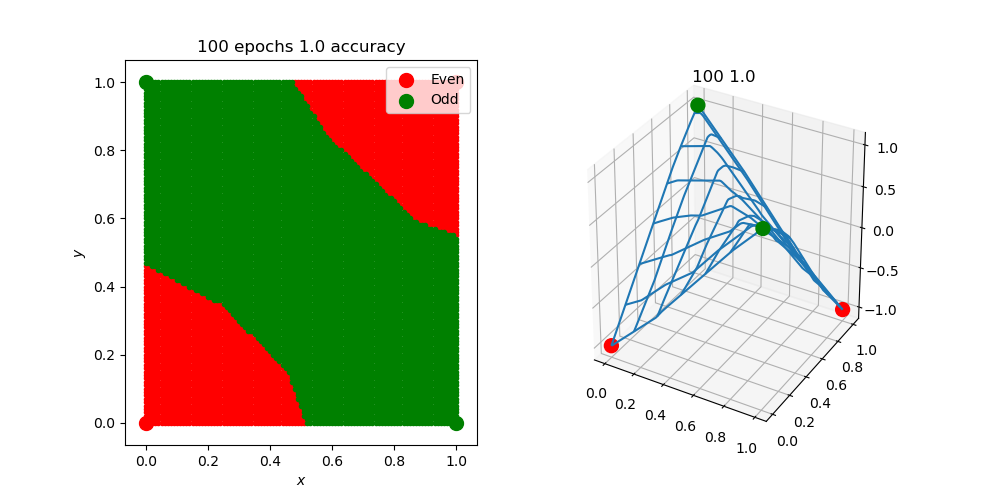

In [38]:
dataLoader = get_dataloader()
network = SimpleNet()
trainNet(network, width=width)

<IPython.core.display.Javascript object>


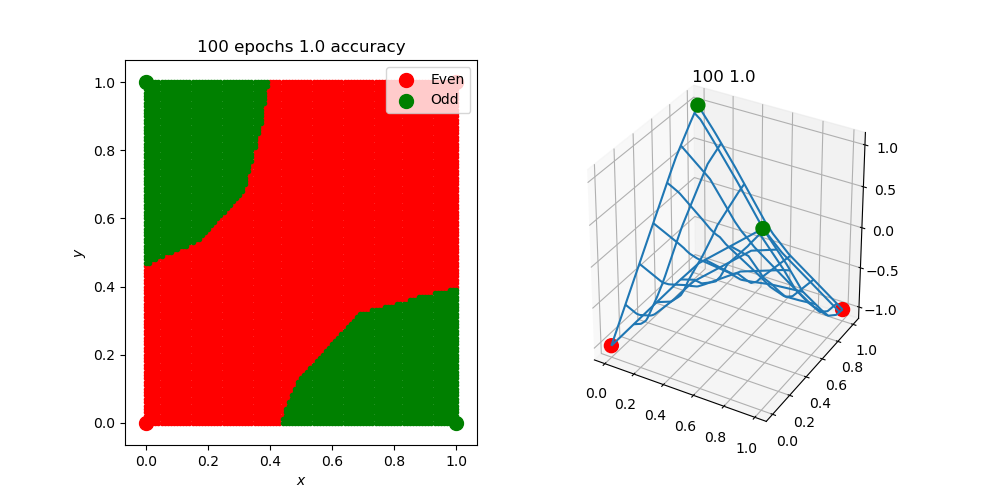

In [39]:
network2 = SimpleNet()
trainNet(network2, width=width)

In [40]:
# Get regions and transforms
inputs, regions, regions2 = getRegions(network, network2)

reg = NumpyLinearRegression()
reg.fit(regions, regions2)

reg2 = NumpyLinearRegression()
reg2.fit(regions2, regions)

regionsSet = np.array(calcUniqueRegions(regions))
regions2Set = np.array(calcUniqueRegions(regions2))

print(len(regionsSet), len(regions2Set))

55 54


<IPython.core.display.Javascript object>


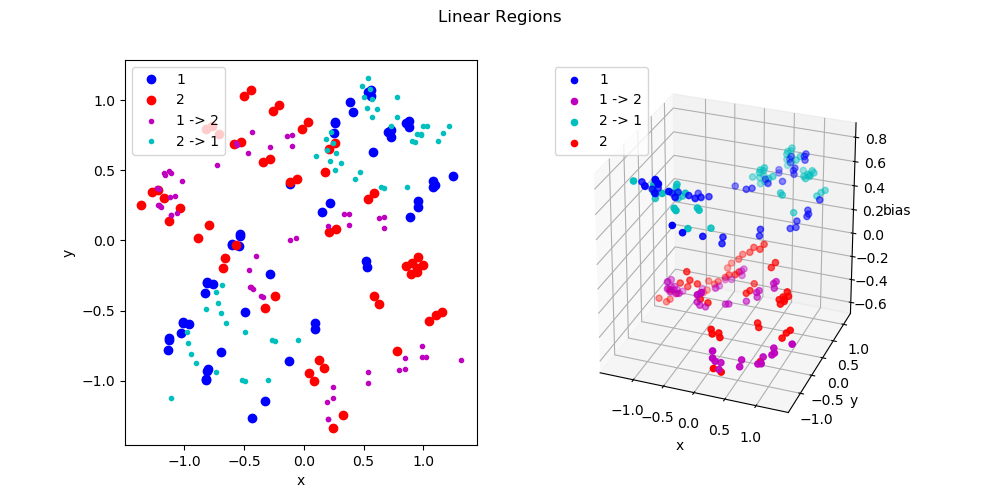

In [41]:
if len(regionsSet) < 200:
    plotLinearRegions(regionsSet, regions2Set, reg, reg2)

<IPython.core.display.Javascript object>


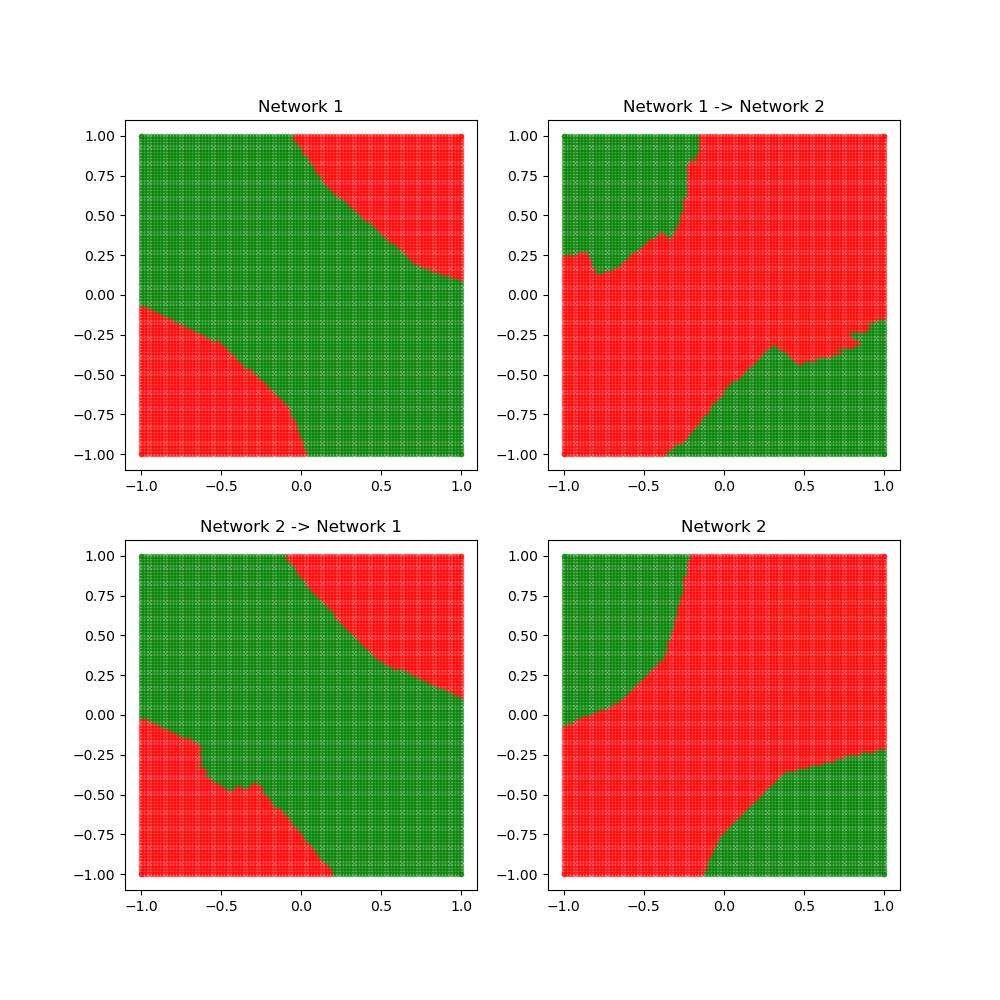

In [42]:
plotSurfaces(inputs, regions,regions2, reg, reg2)

<IPython.core.display.Javascript object>


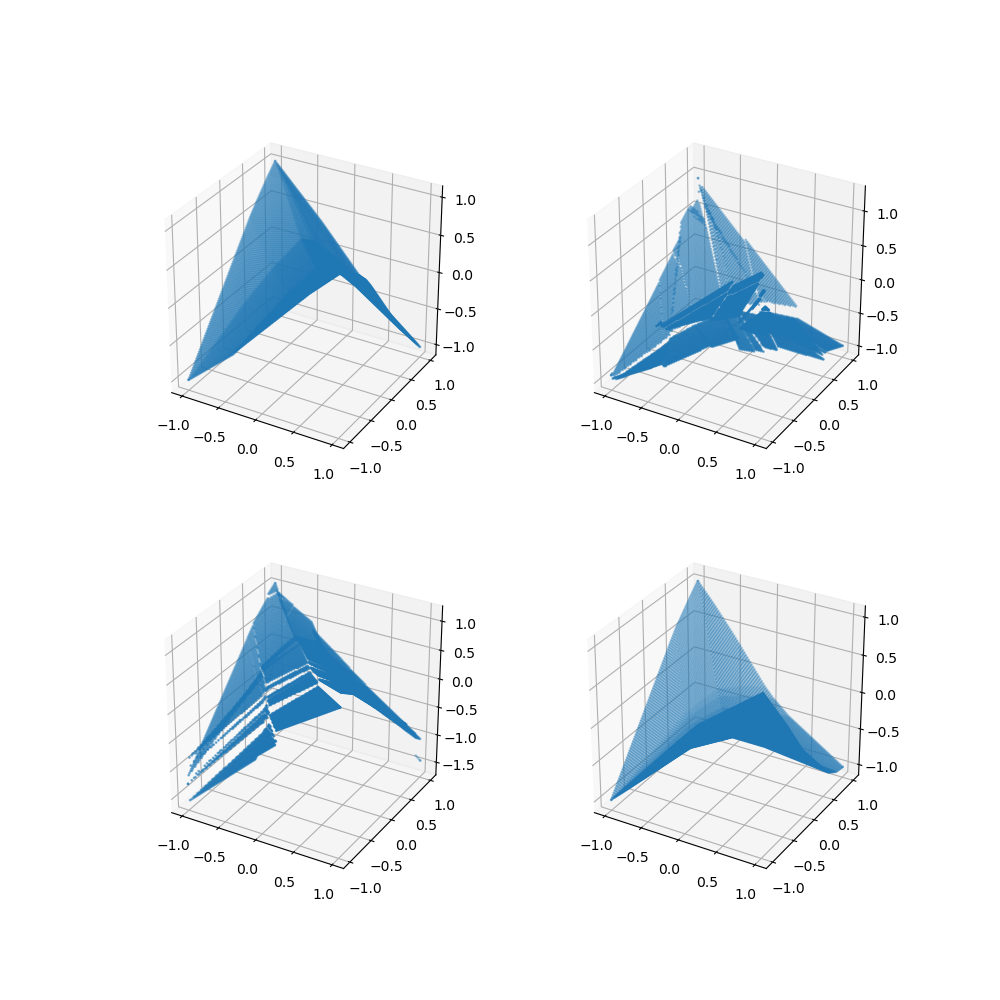

In [43]:
plotWireframes(inputs, regions, regions2, reg, reg2)

# Width 100 networks

In [103]:
width = 100

/home/ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


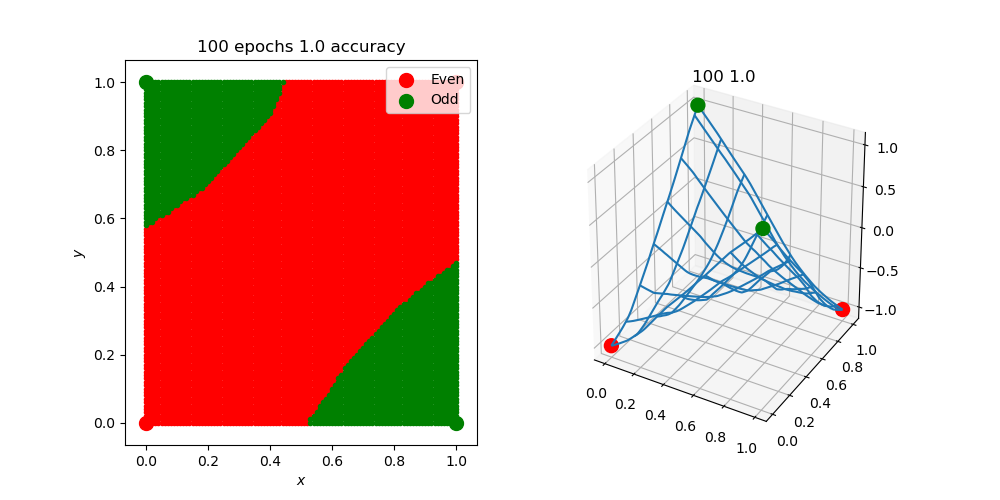

In [104]:
dataLoader = get_dataloader()
network = SimpleNet()
trainNet(network, width=width)

/home/ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


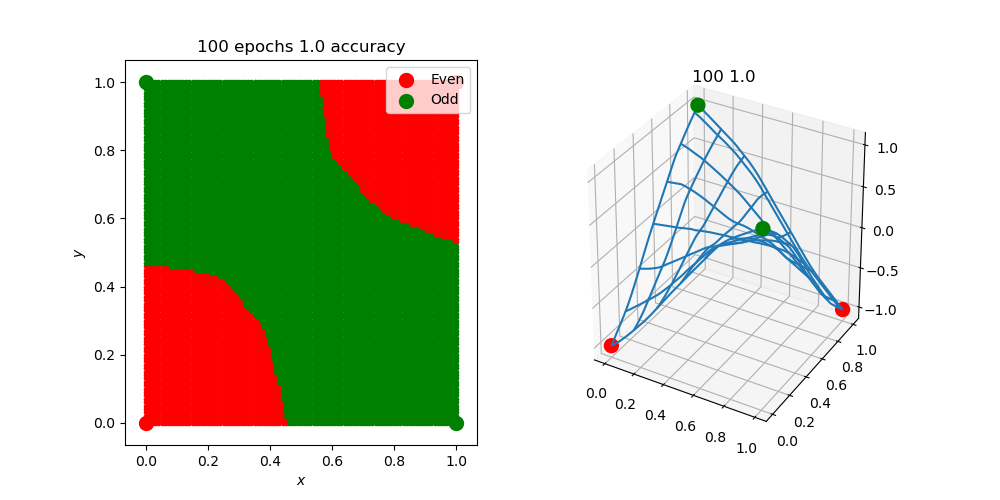

In [106]:
network2 = SimpleNet()
trainNet(network2, width=width)

In [107]:
# Get regions and transforms
inputs, regions, regions2 = getRegions(network, network2)

reg = NumpyLinearRegression()
reg.fit(regions, regions2)

reg2 = NumpyLinearRegression()
reg2.fit(regions2, regions)

regionsSet = np.array(calcUniqueRegions(regions))
regions2Set = np.array(calcUniqueRegions(regions2))

print(len(regionsSet), len(regions2Set))

1079 1399


/home/ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


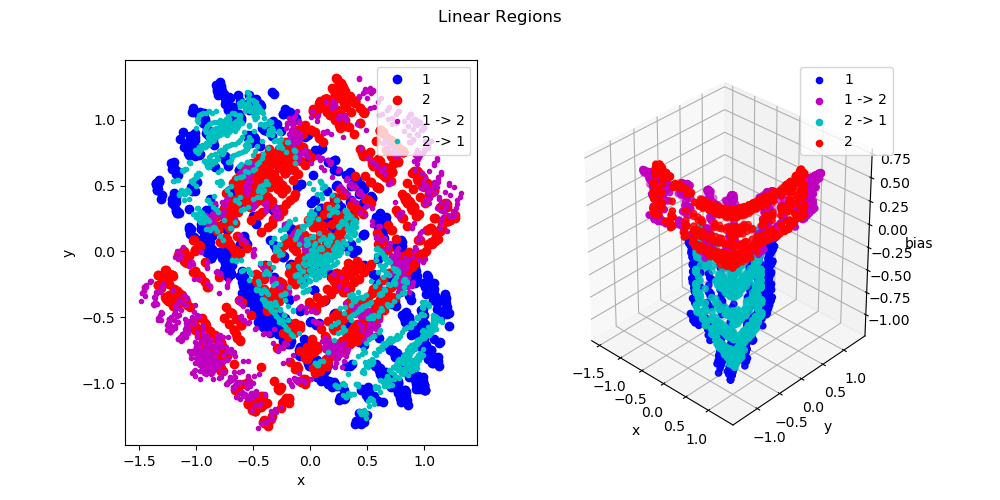

In [108]:
plotLinearRegions(regionsSet, regions2Set, reg, reg2)

/home/ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


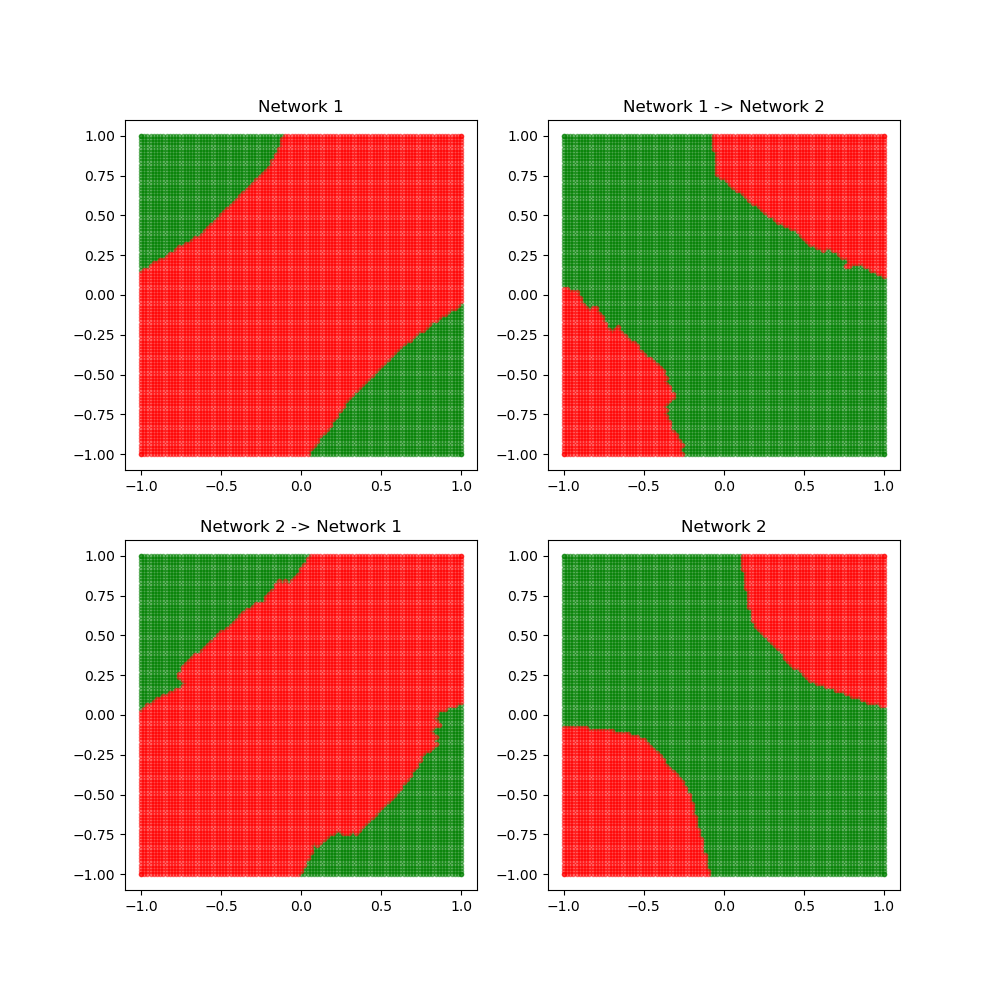

In [109]:
plotSurfaces(inputs, regions,regions2, reg, reg2)

/home/ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


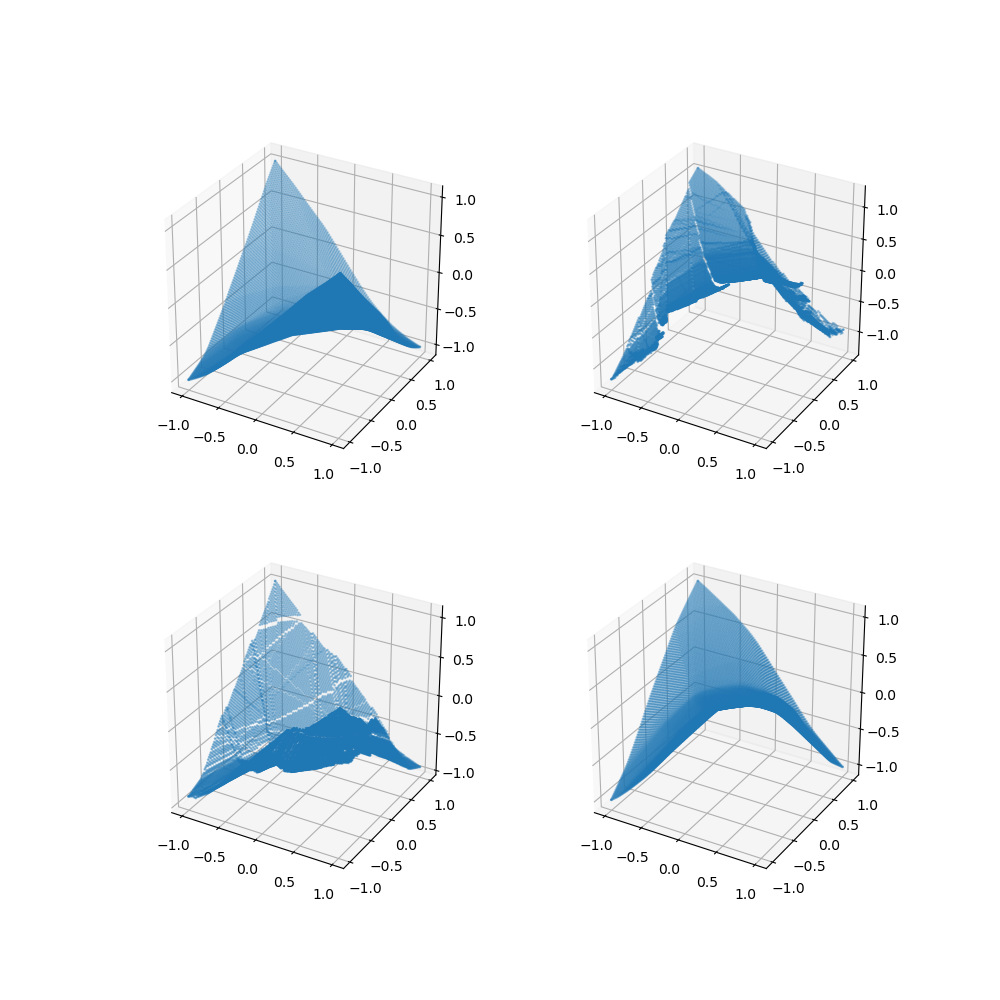

In [110]:
plotWireframes(inputs, regions, regions2, reg, reg2)